In [27]:
from typing import Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.auto import tqdm

## 自己回帰和分移動平均(ARIMA)モデルを定義する

## 非定常時系列を考慮の対処にするために一般的なモデル化手続きを変更する

## 非定常時系列を予測する

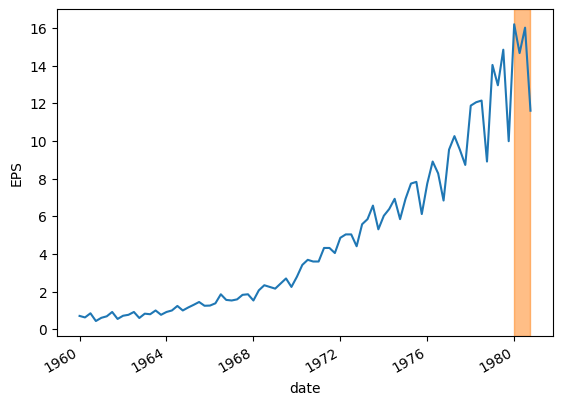

In [40]:
url = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/jj.csv'
df = pd.read_csv(url, parse_dates=['date'], index_col='date')

train = df.iloc[:-4]
test = df.iloc[-4:]

# plot
fig, ax = plt.subplots()
ax.set_ylabel('EPS')
df['data'].plot(ax=ax)
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
plt.show()

In [41]:
for d in [0, 1, 2]:
    ADF_result = adfuller(np.diff(df['data'], n=d))
    print(f'EPS({d}次差分)ADF検定')
    print(f'ADF Statistic: {ADF_result[0]:.3f}')
    print(f'p-value: {ADF_result[1]:.3f}')

EPS(0次差分)ADF検定
ADF Statistic: 2.742
p-value: 1.000
EPS(1次差分)ADF検定
ADF Statistic: -0.407
p-value: 0.909
EPS(2次差分)ADF検定
ADF Statistic: -3.585
p-value: 0.006


In [42]:
# 一意なARIMA(p,q)モデルをすべて適合させる関数
def optimize_ARIMA(endog: Union[pd.Series, list], orders: list, d: int) -> pd.DataFrame:
    """
    endog: 時系列データ
    orders: ARIMA(p, d, q)のpとqの値の組み合わせ
    d: 和分次数
    """
    res = []
    for order in tqdm(orders):
        try:
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                simple_differencing=False
            ).fit(disp=False)
            res.append([order, model.aic])
        except:
            continue
    df_res = (
        pd.DataFrame(res, columns=['(p,q)', 'AIC'])
        .sort_values(by='AIC', ascending=True)
        .reset_index(drop=True)
    )
    return df_res

In [43]:
d = 2 # 上のADF検定から和分次数は2に決定
orders = list(product(range(4), range(4))) # p,qをそれぞれ0~3まで動かす
optimize_ARIMA(df['data'], orders, 2)

  0%|          | 0/16 [00:00<?, ?it/s]

/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

,"(p,q)",AIC
0,"(3, 3)",117.898033
1,"(3, 1)",119.338719
2,"(3, 2)",119.504218
3,"(3, 0)",160.819665
4,"(0, 3)",218.838417
5,"(0, 2)",241.466413
6,"(2, 3)",246.507250
7,"(1, 3)",254.710421
8,"(1, 2)",258.390204
9,"(2, 2)",258.974897


/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed

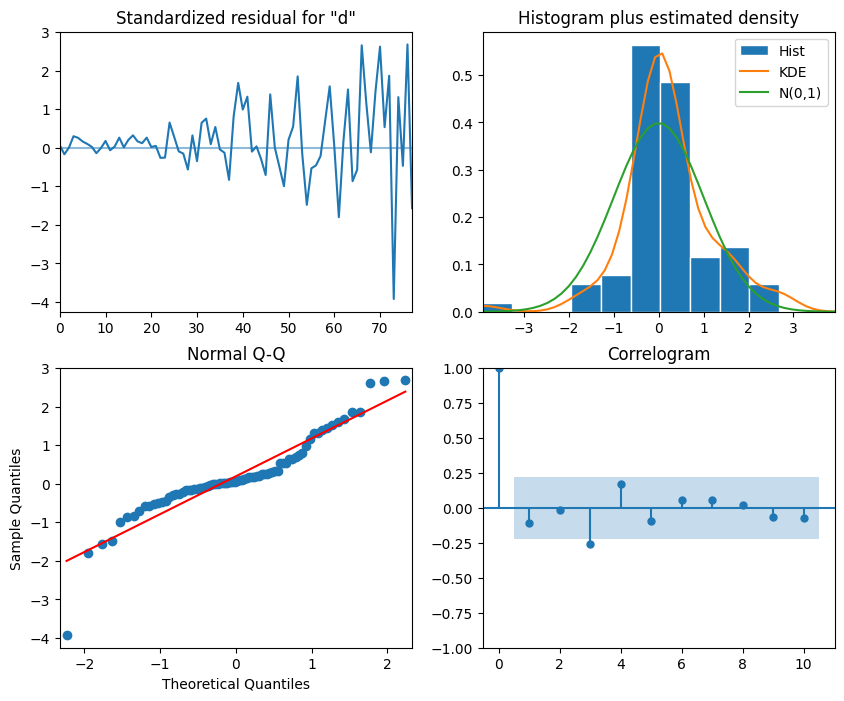

In [44]:
# (3, 3)モデルの残差分析を行う
# 残差分析
model = SARIMAX(train['data'], order=(3, d, 3), simple_differencing=False).fit(disp=False)
model.plot_diagnostics(figsize=(10, 8))
plt.show()

In [45]:
# 残差が無相関かの評価
acorr_ljungbox(model.resid, np.arange(1, 11))

,lb_stat,lb_pvalue
1,1.652020,0.198684
2,1.654544,0.437241
3,7.276173,0.063597
4,9.231226,0.055573
5,9.853425,0.079497
6,10.097125,0.120621
7,10.346926,0.169751
8,10.379005,0.239426
9,10.721222,0.295303
10,11.159917,0.345196


In [46]:
test['naive_seasonal'] = train.iloc[-4:].values
test['pred_ARIMA'] = model.get_prediction(train.shape[0], train.shape[0] + 3).predicted_mean.values

/tmp/ipykernel_1794/416178706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = train.iloc[-4:].values
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/yoneda/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipykernel_1794/416178706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

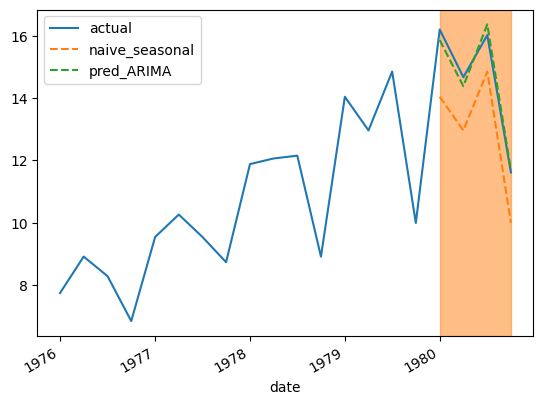

In [51]:
fig, ax = plt.subplots()
df['data'].iloc[-20:].plot(ax=ax, label='actual')
ax.axvspan(test.index[0], test.index[-1], color='tab:orange', alpha=0.5)
methods = ['naive_seasonal', 'pred_ARIMA']
for method in methods:
    test[method].plot(ax=ax, label=method, ls='dashed')
ax.legend()

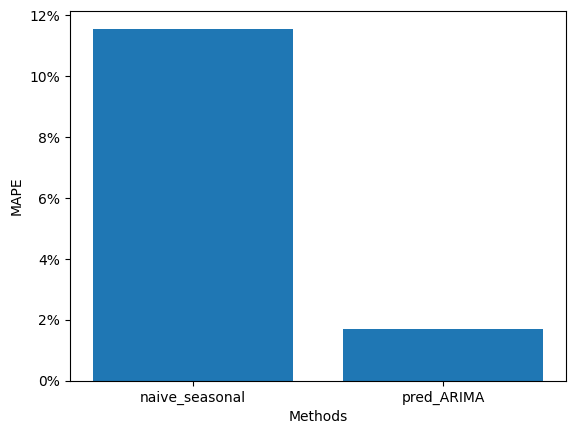

In [54]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

plt.xlabel('Methods')
plt.ylabel('MAPE')
plt.bar(
    methods,
    [mape(test['data'], test[method]) for method in methods]
)
plt.gca().yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y))
plt.show()